# #30DayChartChallenge: Polar Plot Time Series of Modelled Salt Front in the Delaware Bay

In [ ]:
Names: 

### Libraries

In [108]:
import xarray as xr
import pandas as pd
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy
import numpy as np
from datetime import datetime
import xarray.ufuncs as xu
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.dates as mdates
import cmocean.cm
import dask.array as da
import scipy.io
from scipy import signal
import os

### Import Salt Front Data

Read 2016 data

In [23]:
saltfront_2016 = pd.read_csv('saltfront_2016.csv', index_col=0 )
saltfront_2016['date'] = pd.to_datetime(saltfront_2016.index)

Read 2019 data

In [2]:
saltfront_2019 = pd.read_csv('saltfront_2019.csv', index_col=0 )
saltfront_2019['date'] = pd.to_datetime(saltfront_2019.index)

Plot 2016

In [24]:
df_plot_2016 = saltfront_2016
df_plot_2016['year'] = df_plot_2016.date.dt.year # Add column for year

### Setup Data for Plotting 

In [25]:
# Get list of years represented in the dataset
year_listed = df_plot_2016.year.unique()
year_listed

array([2016], dtype=int64)

In [26]:
# Make sure the data covers complete years for all years in the dataset
year_df_idx = pd.date_range(f'01-01-{year_listed[0]}',f'12-31-{year_listed[-1]}')
df_plot_2016.index = pd.DatetimeIndex(df_plot_2016.index)
df_plot_2016 = df_plot_2016.reindex(year_df_idx, fill_value=np.nan)
df_plot_2016['date'] = pd.to_datetime(df_plot_2016.index)

In [27]:
# Add time-related columns
df_plot_2016['year'] = df_plot_2016.date.dt.year # Add column for year
df_plot_2016['mdate'] = mdates.date2num(df_plot_2016.index.to_pydatetime()) # Convert dates to matplotlib dates
df_plot_2016['tnorm'] = np.nan # for now, set normalized time column to NaN
df_plot_2016['doy'] = df_plot_2016.date.dt.dayofyear # compute doy #option 2
df_plot_2016['doy_norm'] = np.nan # for now, set normalized doy column to NaN

In [28]:
# For each year in the dataset
for year in year_listed:
    year_df =  df_plot_2016.loc[df_plot_2016['year']==year]
    # normalize dates for that year to circle (2pi radians)
    df_plot_2016.loc[df_plot_2016['year']==year, 'tnorm'] = (year_df['mdate']-year_df['mdate'].min())/(year_df['mdate'].max()-year_df['mdate'].min())*2.*np.pi
    # normalize DOY for that year to circle (2pi radians)
    df_plot_2016.loc[df_plot_2016['year']==year, 'doy_norm'] = (year_df['doy']-year_df['doy'].min())/(year_df['doy'].max()-year_df['doy'].min())*2.*np.pi

In [29]:
#fill NaNs
df_plot_2016 = df_plot_2016.interpolate(method='linear')

In [30]:
# Use an arbitrary year to get a set of dates for labeling at 8 places around polar chart
# dates_df = pd.DataFrame({'date':pd.date_range(start='2019-01-01', end='2019-12-31')})
dates_df = pd.DataFrame({'date':pd.date_range(start='2016-01-01', end='2016-12-26')})
date_labels = []
for i in range(0,8):
    date_labels.append(dates_df.iloc[round((dates_df.shape[0]/8)*i)].date.strftime("%m/%d"))
date_labels

['01/01', '02/15', '03/31', '05/15', '06/29', '08/14', '09/28', '11/12']

In [31]:
# Get series representing Wilmington river mile
rm_Wilmington = df_plot_2016.copy()
rm_Wilmington['dist_mile'] = 70

In [32]:
# Get series representing south Philadelphia river mile
rm_Philadelphia = df_plot_2016.copy()
rm_Philadelphia['dist_mile'] = 91

In [33]:
# Get series representing north Philadelphia river mile
rm_Philadelphia_max = df_plot_2016.copy()
rm_Philadelphia_max['dist_mile'] = 110

In [34]:
# Set y bound (y axis limits) to be used in the plot
y_bounds = [df_plot_2016.dist_mile.min()-8, df_plot_2016.dist_mile.max()+5]
y_bounds

[39.07270999064798, 86.52913351706164]

### Plot Data

C:\Users\TTHOMP~1\AppData\Local\Temp\1/ipykernel_34352/1571390407.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(date_labels)


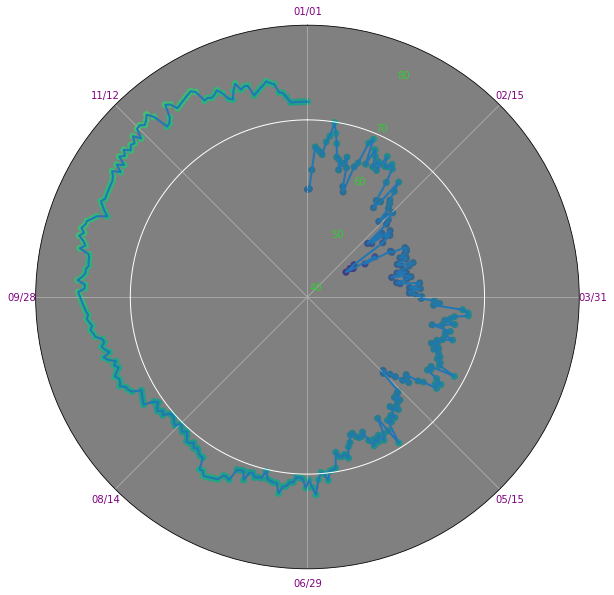

<Figure size 432x288 with 0 Axes>

In [35]:
# Plot w/ normalized date
import matplotlib.colors
import matplotlib.cm

fig = plt.figure(figsize = (10, 10))
ax1 = fig.add_subplot(111, projection='polar')
ax1.set_theta_direction(-1)
ax1.set_theta_zero_location("N")
for year in  year_listed:
    ax1.plot(df_plot_2016.loc[df_plot_2016['year']==year].tnorm,df_plot_2016.loc[df_plot_2016['year']==year].dist_mile, linewidth=2)
    ax1.scatter(df_plot_2016.loc[df_plot_2016['year']==year].doy_norm, df_plot_2016.loc[df_plot_2016['year']==year].dist_mile, c=df_plot_2016.loc[df_plot_2016['year']==year].dist_mile, vmin=37, vmax=100)
# ax1.plot(df_plot['tnorm'],df_plot['dist_mile'], linewidth=2)
ax1.plot(rm_Wilmington['tnorm'],rm_Wilmington['dist_mile'] , linewidth=1, color='white')
ax1.plot(rm_Philadelphia['tnorm'],rm_Philadelphia['dist_mile'] , linewidth=1, color='white')
# ax1.plot(rm_Philadelphia_max['tnorm'],rm_Philadelphia_max['dist_mile'] , linewidth=1, color='white')
# ax1.fill_between(rm_Philadelphia_max['tnorm'],rm_Philadelphia['dist_mile'],rm_Philadelphia_max['dist_mile'], color='white', alpha=0.4)
# ax1.set_rorigin(-5)
ax1.tick_params(axis='y', colors='limegreen')
ax1.tick_params(axis='x', colors='purple')
ax1.set_ylim(y_bounds)
ax1.set_xticklabels(date_labels)
# ax1.set_yticklabels([])
ax1.set_facecolor('grey')
ax1.grid(False, axis='y')
# ax2 = fig.add_subplot(232, sharey=ax1)
# ax2.set_ylim(y_bounds)
# ax2.plot([0,0],y_bounds)
# ax2.set_yticks(y_bounds)
# ax2.set_yticklabels([round(y_bounds[0],0), round(y_bounds[1],0)])
# ax2.axis('off')
plt.show()
plt.savefig('polar_plot_saltfront_2016.png')

In [3]:
df_plot_2019 = saltfront_2019
df_plot_2019['year'] = df_plot_2019.date.dt.year # Add column for year

In [4]:
# Get list of years represented in the dataset
year_listed = df_plot_2019.year.unique()
year_listed

array([2019], dtype=int64)

In [5]:
# Make sure the data covers complete years for all years in the dataset
year_df_idx = pd.date_range(f'01-01-{year_listed[0]}',f'12-31-{year_listed[-1]}')
df_plot_2019.index = pd.DatetimeIndex(df_plot_2019.index)
df_plot_2019 = df_plot_2019.reindex(year_df_idx, fill_value=np.nan)
df_plot_2019['date'] = pd.to_datetime(df_plot_2019.index)

In [6]:
# Add time-related columns
df_plot_2019['year'] = df_plot_2019.date.dt.year # Add column for year
df_plot_2019['mdate'] = mdates.date2num(df_plot_2019.index.to_pydatetime()) # Convert dates to matplotlib dates
df_plot_2019['tnorm'] = np.nan # for now, set normalized time column to NaN
df_plot_2019['doy'] = df_plot_2019.date.dt.dayofyear # compute doy #option 2
df_plot_2019['doy_norm'] = np.nan # for now, set normalized doy column to NaN

In [7]:
# For each year in the dataset
for year in year_listed:
    year_df = df_plot_2019.loc[df_plot_2019['year']==year]
    # normalize dates for that year to circle (2pi radians)
    df_plot_2019.loc[df_plot_2019['year']==year, 'tnorm'] = (year_df['mdate']-year_df['mdate'].min())/(year_df['mdate'].max()-year_df['mdate'].min())*2.*np.pi
    # normalize DOY for that year to circle (2pi radians)
    df_plot_2019.loc[df_plot_2019['year']==year, 'doy_norm'] = (year_df['doy']-year_df['doy'].min())/(year_df['doy'].max()-year_df['doy'].min())*2.*np.pi

In [15]:
#fill NaNs
df_plot_2019 = df_plot_2019.interpolate(method='linear')

In [16]:
# Use an arbitrary year to get a set of dates for labeling at 8 places around polar chart
# dates_df = pd.DataFrame({'date':pd.date_range(start='2019-01-01', end='2019-12-31')})
dates_df = pd.DataFrame({'date':pd.date_range(start='2019-01-01', end='2019-12-26')})
date_labels = []
for i in range(0,8):
    date_labels.append(dates_df.iloc[round((dates_df.shape[0]/8)*i)].date.strftime("%m/%d"))
date_labels

['01/01', '02/15', '04/01', '05/16', '06/30', '08/14', '09/28', '11/12']

In [17]:
# Get series representing Wilmington river mile
rm_Wilmington = df_plot_2019.copy()
rm_Wilmington['dist_mile'] = 70

In [18]:
# Get series representing south Philadelphia river mile
rm_Philadelphia = df_plot_2019.copy()
rm_Philadelphia['dist_mile'] = 91

In [19]:
# Get series representing north Philadelphia river mile
rm_Philadelphia_max = df_plot_2019.copy()
rm_Philadelphia_max['dist_mile'] = 110

In [20]:
# Set y bound (y axis limits) to be used in the plot
y_bounds = [df_plot_2019.dist_mile.min()-8, df_plot_2019.dist_mile.max()+5]
y_bounds

[38.77466698064672, 93.58496888557525]

C:\Users\TTHOMP~1\AppData\Local\Temp\1/ipykernel_34352/657359493.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(date_labels)


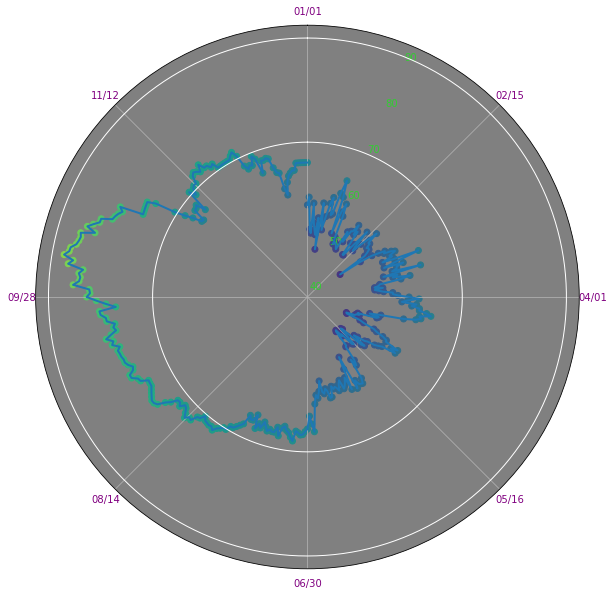

<Figure size 432x288 with 0 Axes>

In [21]:
# Plot w/ normalized date
import matplotlib.colors
import matplotlib.cm

fig = plt.figure(figsize = (10, 10))
ax1 = fig.add_subplot(111, projection='polar')
ax1.set_theta_direction(-1)
ax1.set_theta_zero_location("N")
for year in  year_listed:
    ax1.plot(df_plot_2019.loc[df_plot_2019['year']==year].tnorm,df_plot_2019.loc[df_plot_2019['year']==year].dist_mile, linewidth=2)
    ax1.scatter(df_plot_2019.loc[df_plot_2019['year']==year].doy_norm, df_plot_2019.loc[df_plot_2019['year']==year].dist_mile, c=df_plot_2019.loc[df_plot_2019['year']==year].dist_mile, vmin=37, vmax=100)
# ax1.plot(df_plot['tnorm'],df_plot['dist_mile'], linewidth=2)
ax1.plot(rm_Wilmington['tnorm'],rm_Wilmington['dist_mile'] , linewidth=1, color='white')
ax1.plot(rm_Philadelphia['tnorm'],rm_Philadelphia['dist_mile'] , linewidth=1, color='white')
# ax1.plot(rm_Philadelphia_max['tnorm'],rm_Philadelphia_max['dist_mile'] , linewidth=1, color='white')
# ax1.fill_between(rm_Philadelphia_max['tnorm'],rm_Philadelphia['dist_mile'],rm_Philadelphia_max['dist_mile'], color='white', alpha=0.4)
# ax1.set_rorigin(-5)
ax1.tick_params(axis='y', colors='limegreen')
ax1.tick_params(axis='x', colors='purple')
ax1.set_ylim(y_bounds)
ax1.set_xticklabels(date_labels)
# ax1.set_yticklabels([])
ax1.set_facecolor('grey')
ax1.grid(False, axis='y')
# ax2 = fig.add_subplot(232, sharey=ax1)
# ax2.set_ylim(y_bounds)
# ax2.plot([0,0],y_bounds)
# ax2.set_yticks(y_bounds)
# ax2.set_yticklabels([round(y_bounds[0],0), round(y_bounds[1],0)])
# ax2.axis('off')
plt.show()
plt.savefig('polar_plot_saltfront_2019.png')

### Site Maps

In [36]:
url = 'https://geoport.whoi.edu/thredds/dodsC/vortexfs1/usgs/users/scook/proj/DE_Bay/run07/run07E/run07E_bulk/ocean_deb_his_run07E_bulk_00012.nc'

with xr.set_options(file_cache_maxsize=10):
    ds = xr.open_dataset(url, chunks={'ocean_time':1})

In [54]:
ds.salt

<xarray.DataArray 'salt' (ocean_time: 720, s_rho: 16, eta_rho: 1370, xi_rho: 184)>
dask.array<open_dataset-54c6206aad91510257859278089f5fa4salt, shape=(720, 16, 1370, 184), dtype=float32, chunksize=(1, 16, 1370, 184), chunktype=numpy.ndarray>
Coordinates:
  * s_rho       (s_rho) float64 -0.9688 -0.9062 -0.8438 ... -0.09375 -0.03125
    lon_rho     (eta_rho, xi_rho) float64 dask.array<chunksize=(1370, 184), meta=np.ndarray>
    lat_rho     (eta_rho, xi_rho) float64 dask.array<chunksize=(1370, 184), meta=np.ndarray>
  * ocean_time  (ocean_time) datetime64[ns] 2016-11-26T01:00:00 ... 2016-12-26
Dimensions without coordinates: eta_rho, xi_rho
Attributes:
    long_name:  salinity
    time:       ocean_time
    grid:       grid
    location:   face
    field:      salinity, scalar, series

In [83]:
river_mile_coords = pd.read_csv('river_mile_coords.csv', index_col=0 )
dist_mile = np.array(river_mile_coords.iloc[:,[0]].values)
dist_mile = dist_mile.squeeze()
dist_mile = xr.DataArray(dist_mile,dims=['points']) #change to points
dist_mile = dist_mile.values
river_mile_coords = pd.read_csv('river_mile_coords.csv', index_col=0 )
target_x = np.array(river_mile_coords.iloc[:,[3]].values).squeeze()
target_x = xr.DataArray(target_x-1, dims=["points"]) 
target_y = np.array(river_mile_coords.iloc[:,[4]].values).squeeze()
target_y = xr.DataArray(target_y-1,dims=["points"])

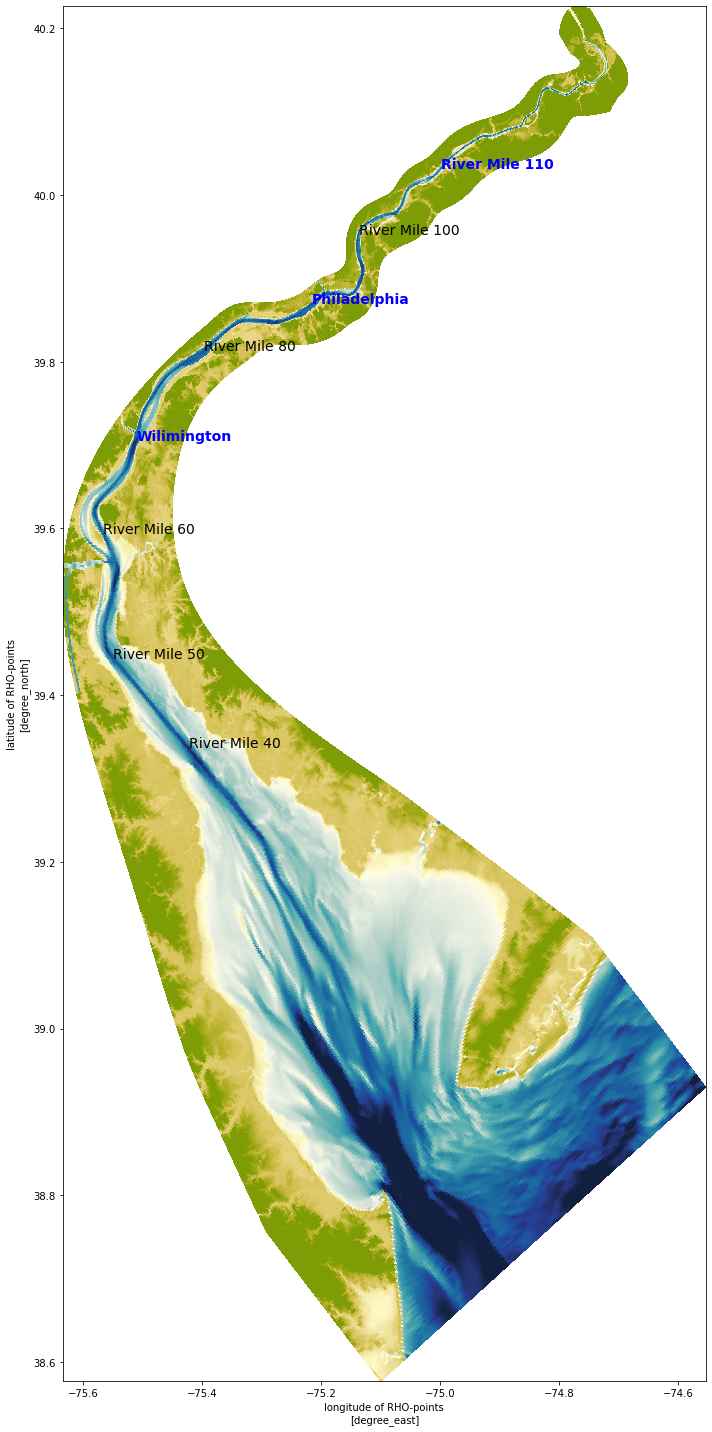

In [104]:
fig, ax = plt.subplots(figsize=(10,20))

newcmap = cmocean.cm.tools.crop(cmocean.cm.delta,vmin=-45,vmax=20,pivot=0)

d = -1*ds['h']
p1 = d.plot(ax=ax,x='lon_rho', y='lat_rho',cmap=newcmap,vmin=-20,vmax=5,add_colorbar=False)

ax.text(-75.42278348, 39.33719356, 'River Mile 40', fontsize=14)
ax.text(-75.55029363, 39.44428867, 'River Mile 50', fontsize=14)
ax.text(-75.56594782, 39.59425391,'River Mile 60', fontsize=14)
ax.text(-75.50988311, 39.70539838, 'Wilimington', weight='bold',fontsize=14,color='blue')
ax.text(-75.3967617, 39.81370734,'River Mile 80', fontsize=14)
# ax.text(-75.22992382, 39.85986636,'River Mile 90', fontsize=14)
ax.text(-75.21498773, 39.87019746,'Philadelphia', weight='bold',fontsize=14,color='blue')
ax.text(-75.13662427, 39.95302179,'River Mile 100', fontsize=14)
ax.text(-74.99779842, 40.0320903,'River Mile 110', weight='bold',fontsize=14,color='blue')


# ax.plot(-75.51889,39.6887,'ro')
# ax.text(-75.51889,39.6887,'Delaware Memorial Bridge',fontsize=14,color='red')

# ax.axis('equal')
# ax.set_ylim([39.6, 39.85])
# ax.set_xlim([-75.61, -75.2])
plt.savefig('site_map_closeup.png')
plt.tight_layout()

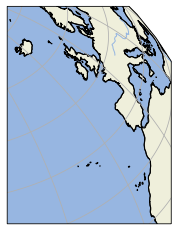

In [114]:
central_lon, central_lat = -75.201416, 39.455282
extent = [-40, 20, 30, 60]
ax = plt.axes(projection=ccrs.Orthographic(central_lon, central_lat))
ax.set_extent(extent)
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.RIVERS)
ax.add_feature(cartopy.feature.LAND, edgecolor='black')
ax.gridlines()
ax.coastlines(resolution='50m')